In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()
seed = 42

In [3]:
%matplotlib inline

# Caveats with Feature Importance

In [124]:
df_raw = pd.read_csv('../data/employee-attrition.csv')
df_raw.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [125]:
categorical_columns = ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'Gender', 'MaritalStatus', 'Over18', 'OverTime', 
'Attrition'
]

df = df_raw.copy()
for col in categorical_columns:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

RF train accuracy: 0.973
RF test accuracy: 0.830


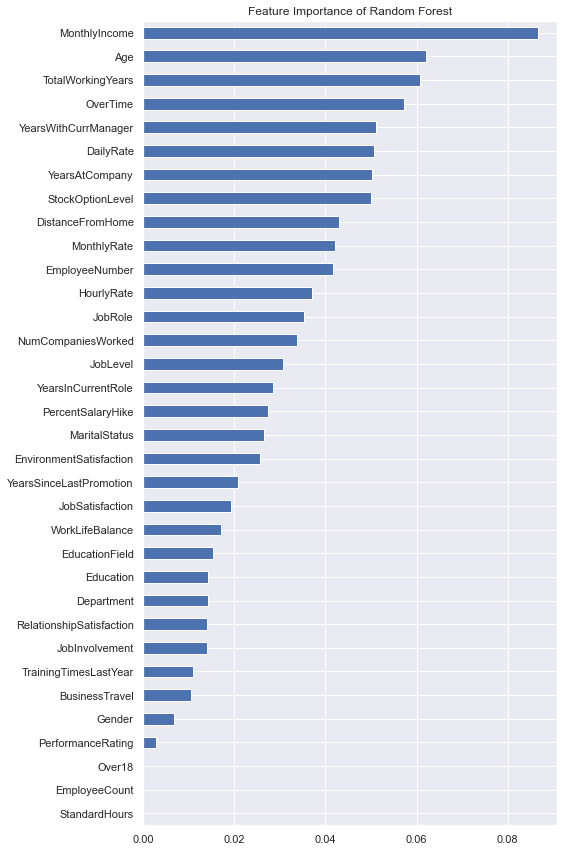

In [126]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('Attrition', axis=1), 
    df.Attrition, test_size=0.2, 
    stratify=df.Attrition,
    random_state=seed
)
clf = RandomForestClassifier(n_estimators=50, min_samples_leaf=5, class_weight='balanced', random_state=seed)
clf.fit(x_train, y_train)
print(f"RF train accuracy: {clf.score(x_train, y_train):0.3f}")
print(f"RF test accuracy: {clf.score(x_test, y_test):0.3f}")

feature_importance = pd.Series(clf.feature_importances_, index=x_train.columns).sort_values(ascending=True)
ax = feature_importance.plot.barh(figsize=(8, 12))
plt.title('Feature Importance of Random Forest')
plt.tight_layout()
plt.savefig('../images/feature_importance1.png', dpi=100)

The random forest gives a strangely high importance to a random variable

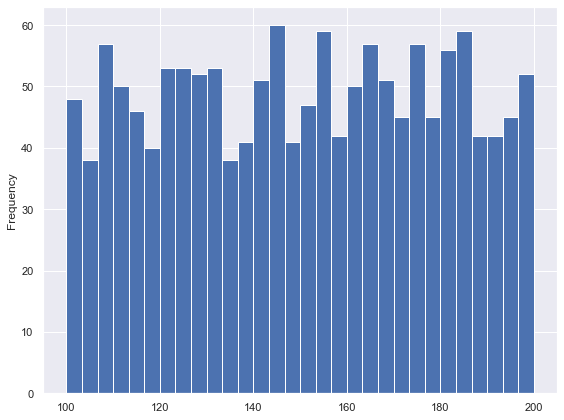

In [127]:
random.seed(seed)
df['continuous_random'] = [random.uniform(100,200) for _ in range(len(df))]
df['continuous_random'].plot.hist(bins=30, figsize=(8, 6))
plt.tight_layout()
plt.savefig('../images/random_continuous_variable.png', dpi=100)

RF train accuracy: 0.969
RF test accuracy: 0.820


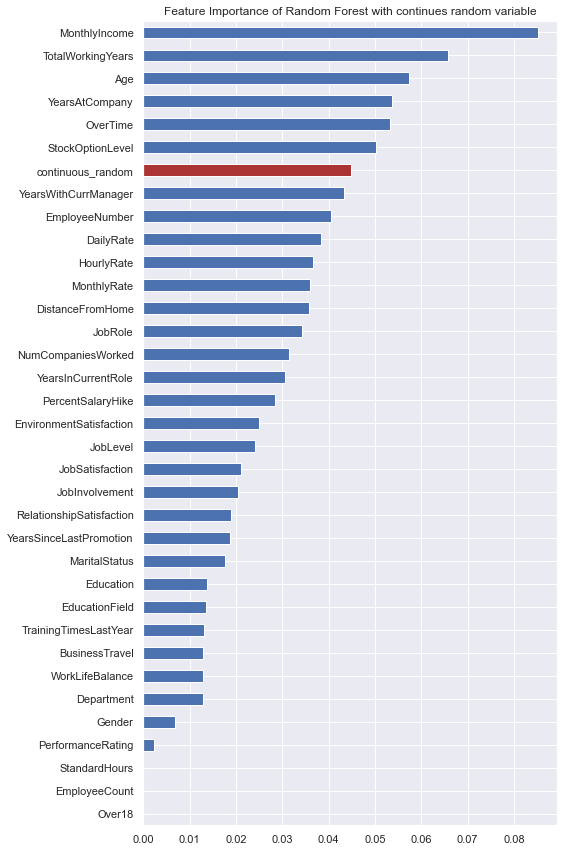

In [128]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('Attrition', axis=1), 
    df.Attrition, 
    test_size=0.2, 
    stratify=df.Attrition,
    random_state=seed
)
clf = RandomForestClassifier(n_estimators=50, min_samples_leaf=5, class_weight='balanced', random_state=seed)
clf.fit(x_train, y_train)

print(f"RF train accuracy: {clf.score(x_train, y_train):0.3f}")
print(f"RF test accuracy: {clf.score(x_test, y_test):0.3f}")

feature_importance = pd.Series(clf.feature_importances_, index=x_train.columns).sort_values(ascending=True)
ax = feature_importance.plot.barh(figsize=(8, 12))

highlight = 'continuous_random'

pos = feature_importance.index.get_loc(highlight)
ax.patches[pos].set_facecolor('#aa3333')

plt.title('Feature Importance of Random Forest with continues random variable')
plt.tight_layout()
plt.savefig('../images/feature_importance2.png', dpi=100)

The random forest assign very different importances to the two variables, although they are both random and hold no information about the target variable. 

In [129]:
df['discrete_random'] = [random.randrange(100, 200, 50) for _ in range(len(df))]

RF train accuracy: 0.974
RF test accuracy: 0.827


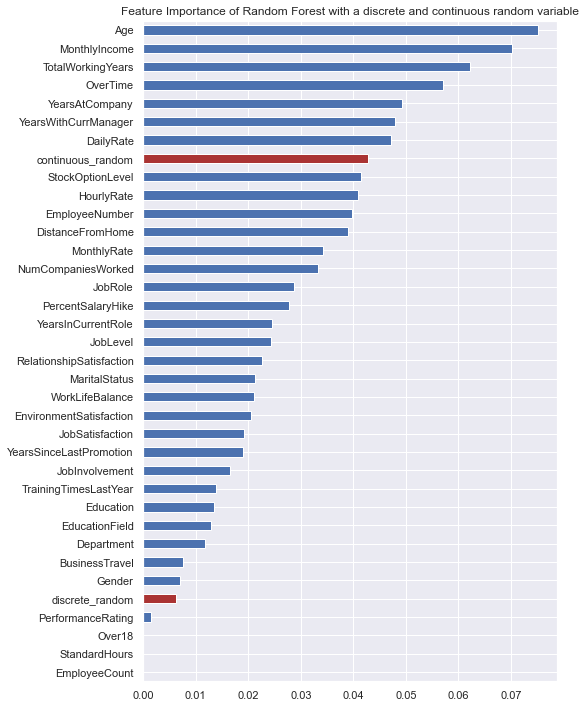

In [130]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('Attrition', axis=1), 
    df.Attrition, 
    test_size=0.2, 
    stratify=df.Attrition, 
    random_state=seed
)

clf = RandomForestClassifier(n_estimators=50, min_samples_leaf=5, class_weight='balanced', random_state=seed)
clf.fit(x_train, y_train)

print(f"RF train accuracy: {clf.score(x_train, y_train):0.3f}")
print(f"RF test accuracy: {clf.score(x_test, y_test):0.3f}")

feature_importance = pd.Series(clf.feature_importances_, index=x_train.columns).sort_values(ascending=True)
ax = feature_importance.plot.barh(figsize=(8, 10))

pos = feature_importance.index.get_loc('continuous_random')
ax.patches[pos].set_facecolor('#aa3333')
pos = feature_importance.index.get_loc('discrete_random')
ax.patches[pos].set_facecolor('#aa3333')

plt.title('Feature Importance of Random Forest with a discrete and continuous random variable')
plt.tight_layout()
plt.savefig('../images/feature_importance3.png', dpi=100)

This is caused by the metric used to calculate feature importance in the random forest: impurity. Without going into details, its the metric that determines how to split in a decision tree and a random forest. 

There are two problems with this metric. From sklearn: 
1. Impurity-based importances are biased towards high cardinality features;
2. Impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity).

Using the permutation importance, we can see the large differences in feature importance between the train and the test set. This is not possible with the `feature_importance`

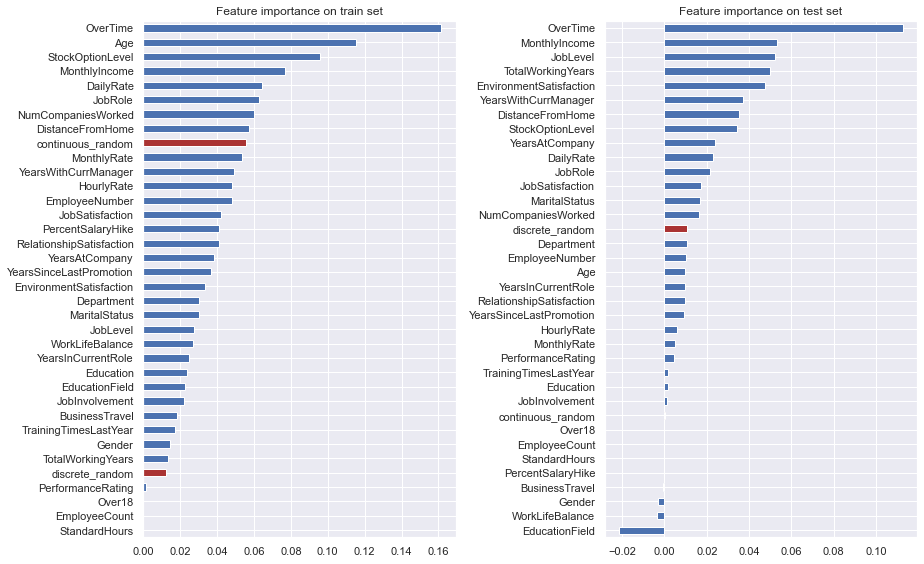

In [121]:
from sklearn.inspection import permutation_importance

# Calculate and plot feature importance test set

r = permutation_importance(clf, x_test, y_test,
                           n_repeats=10,
                           random_state=seed, 
                           n_jobs=-1,
                           scoring='f1'
                           )
perm = pd.DataFrame(columns=['AVG_Importance', 'STD_Importance'], index=x_test.columns)
perm['AVG_Importance'] = r.importances_mean
perm['STD_Importance'] = r.importances_std
perm = perm.sort_values('AVG_Importance')

sorted_idx = r.importances_mean.argsort()
fig, axes = plt.subplots(ncols=2, figsize=(13, 8))
# ax.boxplot(r.importances[sorted_idx].T, vert=False, labels=x_test.columns[sorted_idx])

perm.AVG_Importance.plot.barh(ax=axes[1])

pos = perm.index.get_loc('continuous_random')
axes[1].patches[pos].set_facecolor('#aa3333')
pos = perm.index.get_loc('discrete_random')
axes[1].patches[pos].set_facecolor('#aa3333')
axes[1].title.set_text('Feature importance on test set')

# Calculate and plot feature importance training set

r = permutation_importance(clf, x_train, y_train,
                           n_repeats=10,
                           random_state=seed,
                           n_jobs=-1,
                           scoring='f1'
                           )
perm = pd.DataFrame(columns=['AVG_Importance', 'STD_Importance'], index=x_train.columns)
perm['AVG_Importance'] = r.importances_mean
perm['STD_Importance'] = r.importances_std
perm = perm.sort_values('AVG_Importance')

sorted_idx = r.importances_mean.argsort()

perm.AVG_Importance.plot.barh(ax=axes[0])

pos = perm.index.get_loc('continuous_random')
axes[0].patches[pos].set_facecolor('#aa3333')
pos = perm.index.get_loc('discrete_random')
axes[0].patches[pos].set_facecolor('#aa3333')
axes[0].title.set_text('Feature importance on train set')
fig.tight_layout()

plt.savefig('../images/feature_importance4.png', dpi=100)

<AxesSubplot:>

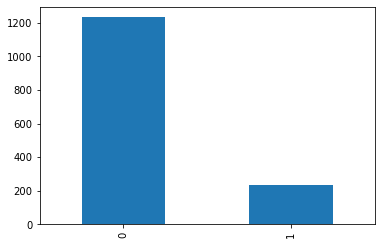

In [73]:
df.Attrition.value_counts().plot(kind='bar')